# Clean Key Words from Hot Reddit Posts
Download required packages textblob for sentiment analysis (polarity and subjectivity)
Download packages required below; Cluster Key words from body by the use of LDA model

In [27]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from textblob import TextBlob
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from','subject','re','edu','use'])

## Import Data

In [5]:
data = pd.read_csv("./Datasets/group_posts.csv",index_col=0)
data.head()

,title,score,id,subreddit,url,num_comments,body,num_subscribers,created_date,post_type,engagement,ER
0,Our most-broken and least-understood rules is ...,1593,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,109,We understand that most people who reply immed...,603300,2019-10-29,text,1702,0.282115
1,Regular Check-In Post,151,exo6f1,depression,https://www.reddit.com/r/depression/comments/e...,862,Welcome to /r/depression's check-in post - a p...,603300,2020-02-02,text,1013,0.167910
2,Does anyone else just wanna start new,595,f4re4h,depression,https://www.reddit.com/r/depression/comments/f...,109,I just want to move to a town where no one kno...,603300,2020-02-16,text,704,0.116692
3,I wanna get sick for a few weeks to catch a break,230,f4u8i2,depression,https://www.reddit.com/r/depression/comments/f...,30,This is prob really messed up but i kind of ju...,603300,2020-02-17,text,260,0.043096
4,I don't want you to ask me if I am feeling bet...,39,f4uix8,depression,https://www.reddit.com/r/depression/comments/f...,2,"The moment you ask me that, I automatically fe...",603300,2020-02-17,text,41,0.006796


# Sentiment analysis for title
Use attributes of polarity and subjectivity to analyze title

In [6]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['title_pol'] = data['title'].apply(pol)
data['title_sub'] = data['title'].apply(sub)
data.head()

,title,score,id,subreddit,url,num_comments,body,num_subscribers,created_date,post_type,engagement,ER,title_pol,title_sub
0,Our most-broken and least-understood rules is ...,1593,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,109,We understand that most people who reply immed...,603300,2019-10-29,text,1702,0.282115,0.128788,0.387626
1,Regular Check-In Post,151,exo6f1,depression,https://www.reddit.com/r/depression/comments/e...,862,Welcome to /r/depression's check-in post - a p...,603300,2020-02-02,text,1013,0.167910,0.000000,0.076923
2,Does anyone else just wanna start new,595,f4re4h,depression,https://www.reddit.com/r/depression/comments/f...,109,I just want to move to a town where no one kno...,603300,2020-02-16,text,704,0.116692,0.136364,0.454545
3,I wanna get sick for a few weeks to catch a break,230,f4u8i2,depression,https://www.reddit.com/r/depression/comments/f...,30,This is prob really messed up but i kind of ju...,603300,2020-02-17,text,260,0.043096,-0.457143,0.478571
4,I don't want you to ask me if I am feeling bet...,39,f4uix8,depression,https://www.reddit.com/r/depression/comments/f...,2,"The moment you ask me that, I automatically fe...",603300,2020-02-17,text,41,0.006796,0.500000,0.500000


## Use LDA model to cluster key words from body

### Set up datasets

In [16]:
# we only need title and body from above datasets
df = data[['title','body']]
df.head()

,title,body
0,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...
1,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...
2,Does anyone else just wanna start new,I just want to move to a town where no one kno...
3,I wanna get sick for a few weeks to catch a break,This is prob really messed up but i kind of ju...
4,I don't want you to ask me if I am feeling bet...,"The moment you ask me that, I automatically fe..."


### Remove unnecesary characters

In [20]:
# convert to list
content = df.body.values.tolist()

# remove new line character
content = [re.sub('\s+', ' ', word) for word in content]

# remove single quotes
content = [re.sub("\'", "", word) for word in content]

# remove *
content = [re.sub("\*", ' ', word) for word in content]

# remove /r/
content = [re.sub("/r/", ' ', word) for word in content]

pprint(content[:1])

['We understand that most people who reply immediately to an OP with an '
 'invitation to talk privately mean only to help, but this type of response '
 'usually leads to either disappointment or disaster. it usually works out '
 'quite differently here than when you say "PM me anytime" in a casual social '
 'context. We have huge admiration and appreciation for the goodwill and good '
 'citizenship of so many of you who support others here and flag inappropriate '
 'content - even more so because we know that so many of you are struggling '
 'yourselves. Were hard at work behind the scenes on more information and '
 'resources to make it easier to give and get quality help here - this is just '
 'a small start. Our new wiki page explains in detail why its much better to '
 'respond in public comments, at least until youve gotten to know someone. It '
 'will be maintained at  depression/wiki/private_contact, and the full text of '
 'the current version is below.       ###Summary###   A

### Functions for text cleaning

In [21]:
def content_to_words(sentences):
    """
    Transform string to list
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words_list = list(content_to_words(content))

print(words_list[:1])

[['we', 'understand', 'that', 'most', 'people', 'who', 'reply', 'immediately', 'to', 'an', 'op', 'with', 'an', 'invitation', 'to', 'talk', 'privately', 'mean', 'only', 'to', 'help', 'but', 'this', 'type', 'of', 'response', 'usually', 'leads', 'to', 'either', 'disappointment', 'or', 'disaster', 'it', 'usually', 'works', 'out', 'quite', 'differently', 'here', 'than', 'when', 'you', 'say', 'pm', 'me', 'anytime', 'in', 'casual', 'social', 'context', 'we', 'have', 'huge', 'admiration', 'and', 'appreciation', 'for', 'the', 'goodwill', 'and', 'good', 'citizenship', 'of', 'so', 'many', 'of', 'you', 'who', 'support', 'others', 'here', 'and', 'flag', 'inappropriate', 'content', 'even', 'more', 'so', 'because', 'we', 'know', 'that', 'so', 'many', 'of', 'you', 'are', 'struggling', 'yourselves', 'were', 'hard', 'at', 'work', 'behind', 'the', 'scenes', 'on', 'more', 'information', 'and', 'resources', 'to', 'make', 'it', 'easier', 'to', 'give', 'and', 'get', 'quality', 'help', 'here', 'this', 'is', '

### Bigram and Trigram models

In [22]:
# Bigram: two words frequently occuring (2-word phrase)
# Trigram: 3-word phrase
bigram = gensim.models.Phrases(content, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[content], threshold=100)

# build bigram and trigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[words_list[0]]])

['we', 'understand', 'that', 'most', 'people', 'who', 'reply', 'immediately', 'to', 'an', 'op', 'with', 'an', 'invitation', 'to', 'talk', 'privately', 'mean', 'only', 'to', 'help', 'but', 'this', 'type', 'of', 'response', 'usually', 'leads', 'to', 'either', 'disappointment', 'or', 'disaster', 'it', 'usually', 'works', 'out', 'quite', 'differently', 'here', 'than', 'when', 'you', 'say', 'pm', 'me', 'anytime', 'in', 'casual', 'social', 'context', 'we', 'have', 'huge', 'admiration', 'and', 'appreciation', 'for', 'the', 'goodwill', 'and', 'good', 'citizenship', 'of', 'so', 'many', 'of', 'you', 'who', 'support', 'others', 'here', 'and', 'flag', 'inappropriate', 'content', 'even', 'more', 'so', 'because', 'we', 'know', 'that', 'so', 'many', 'of', 'you', 'are', 'struggling', 'yourselves', 'were', 'hard', 'at', 'work', 'behind', 'the', 'scenes', 'on', 'more', 'information', 'and', 'resources', 'to', 'make', 'it', 'easier', 'to', 'give', 'and', 'get', 'quality', 'help', 'here', 'this', 'is', 'j

In [24]:
# Remove stopwords and make bigrams and lemmatize
# gensim's simple_preprocess removes punctuation and some unnecessary chars
def remove_stopwords(texts):
    """
    Remove stopwords
    """
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    """
    Bigram
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Trigram
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Break sentences into pieces of words 
    https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# remove stop words
words_nonstop = remove_stopwords(words_list)

# form bigrams
words_bigrams = make_bigrams(words_nonstop)

nlp = spacy.load('en', disable=['parser','ner'])

# lemmatization to keep noun, adj, vb, adv
data_lemmatized = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['understand', 'people', 'reply', 'immediately', 'op', 'invitation', 'talk', 'privately', 'mean', 'help', 'type', 'response', 'usually', 'lead', 'disappointment', 'disaster', 'usually', 'work', 'quite', 'differently', 'say', 'pm', 'anytime', 'casual', 'social', 'context', 'huge', 'admiration', 'appreciation', 'goodwill', 'good', 'citizenship', 'many', 'support', 'other', 'flag', 'inappropriate', 'content', 'even', 'know', 'many', 'struggle', 'hard', 'work', 'scene', 'information', 'resource', 'make', 'easy', 'give', 'get', 'quality', 'help', 'small', 'start', 'new', 'wiki', 'page', 'explain', 'detail', 'much', 'better', 'respond', 'public', 'comment', 'least', 'have', 'get', 'know', 'maintain', 'depression', 'wiki', 'full', 'text', 'current', 'version', 'summary', 'act', 'helper', 'invite', 'accept', 'private', 'contact', 'chat', 'offsite', 'communication', 'early', 'conversion', 'show', 'bad', 'intention', 'bad', 'judgement', 'way', 'unwise', 'trust', 'pm', 'anytime', 'seem', 'kind',

### Create input for topic modeling
Input: dictionary id2word and corpus

In [28]:
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 3), (54, 2), (55, 2), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 3), (84, 3), (85, 4), (86, 1), (87, 2), (88, 1), (89, 2), (90, 1), (91, 7), (92, 2), (93, 5), (94, 6), (95, 1), (96, 2), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2)

In [29]:
# human-readable
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('able', 1),
  ('abuse', 1),
  ('abuser', 1),
  ('accept', 2),
  ('account', 2),
  ('act', 1),
  ('admiration', 1),
  ('age', 1),
  ('agency', 1),
  ('allow', 3),
  ('alone', 1),
  ('analogously', 1),
  ('anonymous', 1),
  ('anytime', 2),
  ('anywhere', 1),
  ('apply', 1),
  ('appreciation', 1),
  ('ask', 1),
  ('assumption', 1),
  ('availability', 1),
  ('bad', 2),
  ('best', 1),
  ('better', 1),
  ('caller', 2),
  ('can', 1),
  ('careful', 1),
  ('casual', 1),
  ('change', 1),
  ('chat', 1),
  ('citizenship', 1),
  ('cognitive', 1),
  ('comment', 1),
  ('commitment', 1),
  ('common', 1),
  ('communicate', 2),
  ('communication', 1),
  ('community', 3),
  ('comorbid', 1),
  ('compassion', 1),
  ('concerned', 1),
  ('consider', 1),
  ('consistently', 1),
  ('contact', 2),
  ('content', 1),
  ('context', 1),
  ('contrary', 1),
  ('conversation', 1),
  ('conversion', 1),
  ('crisis', 2),
  ('critical', 1),
  ('current', 1),
  ('deceptive', 1),
  ('depression', 3),
  (

### Build LDA Model

In [34]:
# Build LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"post" + 0.016*"flair" + 0.015*"people" + 0.015*"try" + 0.010*"know" '
  '+ 0.009*"get" + 0.008*"would" + 0.007*"be" + 0.007*"make" + 0.007*"ask"'),
 (1,
  '0.025*"text" + 0.021*"post" + 0.016*"comment" + 0.014*"be" + 0.012*"go" + '
  '0.010*"people" + 0.009*"leave" + 0.009*"s" + 0.009*"job" + 0.007*"say"'),
 (2,
  '0.028*"feel" + 0.028*"be" + 0.026*"panic" + 0.018*"attack" + 0.018*"time" + '
  '0.014*"get" + 0.014*"have" + 0.014*"would" + 0.011*"life" + 0.010*"know"'),
 (3,
  '0.012*"help" + 0.012*"mental" + 0.012*"people" + 0.012*"health" + '
  '0.010*"helper" + 0.010*"op" + 0.009*"want" + 0.008*"much" + 0.007*"usually" '
  '+ 0.007*"privately"'),
 (4,
  '0.021*"anxiety" + 0.020*"recovery" + 0.012*"look" + 0.011*"still" + '
  '0.011*"go" + 0.010*"have" + 0.010*"panic" + 0.009*"get" + 0.009*"symptom" + '
  '0.008*"be"'),
 (5,
  '0.021*"panic" + 0.019*"feel" + 0.015*"make" + 0.014*"attack" + 0.012*"time" '
  '+ 0.010*"know" + 0.010*"heart" + 0.010*"pain" + 0.010*"lot" + 0

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

# Compute topic coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.721100276262319

Coherence Score:  0.43205348224615253


### Uncomment below to visualize word clustering

In [39]:
# Visualize
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

### Find Optimal number of topics

In [44]:
import os
from gensim.models.wrappers import LdaMallet

mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [45]:
# show topics
pprint(ldamallet.show_topics(formatted=False))

# # Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('health', 0.09243697478991597),
   ('good', 0.06722689075630252),
   ('helper', 0.05042016806722689),
   ('op', 0.05042016806722689),
   ('long', 0.04201680672268908),
   ('healthy', 0.03361344537815126),
   ('depression', 0.03361344537815126),
   ('supportive', 0.03361344537815126),
   ('offer', 0.03361344537815126),
   ('conversation', 0.025210084033613446)]),
 (1,
  [('post', 0.2391304347826087),
   ('comment', 0.07971014492753623),
   ('rule', 0.06521739130434782),
   ('remove', 0.050724637681159424),
   ('reddit', 0.036231884057971016),
   ('guy', 0.036231884057971016),
   ('place', 0.028985507246376812),
   ('app', 0.028985507246376812),
   ('apply', 0.021739130434782608),
   ('step', 0.021739130434782608)]),
 (19,
  [('work', 0.07692307692307693),
   ('mental', 0.07692307692307693),
   ('response', 0.038461538461538464),
   ('develop', 0.038461538461538464),
   ('set', 0.028846153846153848),
   ('contact', 0.028846153846153848),
   ('nervous', 0.028846153846153848),
  

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

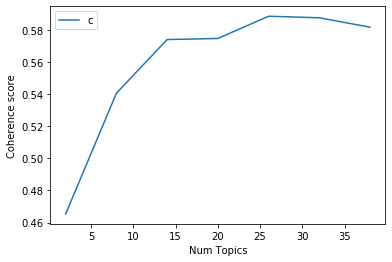

In [52]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4654
Num Topics = 8  has Coherence Value of 0.5405
Num Topics = 14  has Coherence Value of 0.5739
Num Topics = 20  has Coherence Value of 0.5746
Num Topics = 26  has Coherence Value of 0.5884
Num Topics = 32  has Coherence Value of 0.5874
Num Topics = 38  has Coherence Value of 0.5816


In [54]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.245*"people" + 0.059*"guy" + 0.049*"remember" + 0.029*"thing" + '
  '0.020*"literally" + 0.020*"misrepresent" + 0.020*"deep" + '
  '0.020*"additional" + 0.020*"prefer" + 0.020*"stay"'),
 (1,
  '0.112*"anxiety" + 0.105*"recovery" + 0.056*"symptom" + 0.049*"lose" + '
  '0.049*"step" + 0.042*"physical" + 0.042*"fear" + 0.035*"derealization" + '
  '0.028*"find" + 0.028*"recover"'),
 (2,
  '0.108*"struggle" + 0.084*"high" + 0.084*"leave" + 0.084*"start" + '
  '0.036*"move" + 0.036*"thought" + 0.024*"safe" + 0.024*"seek" + '
  '0.024*"doctor" + 0.024*"show"'),
 (3,
  '0.178*"post" + 0.067*"comment" + 0.067*"flair" + 0.044*"rule" + '
  '0.039*"community" + 0.033*"user" + 0.033*"add" + 0.028*"meme" + '
  '0.028*"easy" + 0.028*"app"'),
 (4,
  '0.185*"text" + 0.062*"choose" + 0.046*"set" + 0.046*"phone" + '
  '0.046*"normal" + 0.046*"ago" + 0.046*"discord" + 0.031*"upvote" + '
  '0.015*"headache" + 0.015*"basically"'),
 (5,
  '0.083*"lot" + 0.073*"experience" + 0.052*"chest" + 0.052*"p

### Key words summary

In [56]:
# Aggregate information
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=content):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=content)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2473,"health, mental, good, op, helper, pm, healthy,...",We understand that most people who reply immed...
1,1,3.0,0.1604,"post, comment, flair, rule, community, user, a...",Welcome to depressions check-in post - a plac...
2,2,2.0,0.0960,"struggle, high, leave, start, move, thought, s...",I just want to move to a town where no one kno...
3,3,17.0,0.1235,"bed, suicide, find, girl, describe, tired, mes...",This is prob really messed up but i kind of ju...
4,4,11.0,0.1402,"feel, feeling, time, sense, fall, make, call, ...","The moment you ask me that, I automatically fe..."
5,5,8.0,0.1689,"time, life, day, hope, friend, beat, end, due,...",tw: suicide I am 2 months and 13 days out from...
6,6,7.0,0.0943,"point, share, stop, place, drive, nervous, thi...",Ive finally figured out what the crunchy sound...
7,7,17.0,0.1190,"bed, suicide, find, girl, describe, tired, mes...",I’m 22. Stuck in a job after graduating univer...
8,8,3.0,0.1801,"post, comment, flair, rule, community, user, a...",When I post here I dont expect to get any resp...
9,9,2.0,0.0917,"struggle, high, leave, start, move, thought, s...",I didnt choose life I was literally forced int...


In [57]:
df_dominant_topic.to_csv("./Datasets/Key_Words_Posts.csv")

### Merge findings with master datasets

In [58]:
Results = pd.merge(data, df_dominant_topic, left_index=True, right_index=True)
Results.head()

,title,score,id,subreddit,url,num_comments,body,num_subscribers,created_date,post_type,engagement,ER,title_pol,title_sub,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Our most-broken and least-understood rules is ...,1593,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,109,We understand that most people who reply immed...,603300,2019-10-29,text,1702,0.282115,0.128788,0.387626,0,9.0,0.2473,"health, mental, good, op, helper, pm, healthy,...",We understand that most people who reply immed...
1,Regular Check-In Post,151,exo6f1,depression,https://www.reddit.com/r/depression/comments/e...,862,Welcome to /r/depression's check-in post - a p...,603300,2020-02-02,text,1013,0.167910,0.000000,0.076923,1,3.0,0.1604,"post, comment, flair, rule, community, user, a...",Welcome to depressions check-in post - a plac...
2,Does anyone else just wanna start new,595,f4re4h,depression,https://www.reddit.com/r/depression/comments/f...,109,I just want to move to a town where no one kno...,603300,2020-02-16,text,704,0.116692,0.136364,0.454545,2,2.0,0.0960,"struggle, high, leave, start, move, thought, s...",I just want to move to a town where no one kno...
3,I wanna get sick for a few weeks to catch a break,230,f4u8i2,depression,https://www.reddit.com/r/depression/comments/f...,30,This is prob really messed up but i kind of ju...,603300,2020-02-17,text,260,0.043096,-0.457143,0.478571,3,17.0,0.1235,"bed, suicide, find, girl, describe, tired, mes...",This is prob really messed up but i kind of ju...
4,I don't want you to ask me if I am feeling bet...,39,f4uix8,depression,https://www.reddit.com/r/depression/comments/f...,2,"The moment you ask me that, I automatically fe...",603300,2020-02-17,text,41,0.006796,0.500000,0.500000,4,11.0,0.1402,"feel, feeling, time, sense, fall, make, call, ...","The moment you ask me that, I automatically fe..."


In [61]:
Results.drop(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib','Text'], axis=1, inplace=True)
Results.head()

,title,score,id,subreddit,url,num_comments,body,num_subscribers,created_date,post_type,engagement,ER,title_pol,title_sub,Keywords
0,Our most-broken and least-understood rules is ...,1593,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,109,We understand that most people who reply immed...,603300,2019-10-29,text,1702,0.282115,0.128788,0.387626,"health, mental, good, op, helper, pm, healthy,..."
1,Regular Check-In Post,151,exo6f1,depression,https://www.reddit.com/r/depression/comments/e...,862,Welcome to /r/depression's check-in post - a p...,603300,2020-02-02,text,1013,0.167910,0.000000,0.076923,"post, comment, flair, rule, community, user, a..."
2,Does anyone else just wanna start new,595,f4re4h,depression,https://www.reddit.com/r/depression/comments/f...,109,I just want to move to a town where no one kno...,603300,2020-02-16,text,704,0.116692,0.136364,0.454545,"struggle, high, leave, start, move, thought, s..."
3,I wanna get sick for a few weeks to catch a break,230,f4u8i2,depression,https://www.reddit.com/r/depression/comments/f...,30,This is prob really messed up but i kind of ju...,603300,2020-02-17,text,260,0.043096,-0.457143,0.478571,"bed, suicide, find, girl, describe, tired, mes..."
4,I don't want you to ask me if I am feeling bet...,39,f4uix8,depression,https://www.reddit.com/r/depression/comments/f...,2,"The moment you ask me that, I automatically fe...",603300,2020-02-17,text,41,0.006796,0.500000,0.500000,"feel, feeling, time, sense, fall, make, call, ..."


In [63]:
Results.to_csv("./Datasets/Results.csv")

In [ ]:
# reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/